In [1]:
using Molly
using Unitful
using ConstrainedDynamicsSimulator

In [2]:
# Propane was modeled using a custom GAFF2-based force field, with AM1-BCC charges assigned to reproduce electrostatic potentials. Bonded (bonds, angles, torsions) and nonbonded (van der Waals, Coulomb) interactions were parameterized and converted into OpenMM XML format for use in Molly, preserving atom types and residue names to maintain molecular topology and ensure accurate energy and force calculations during simulations.

# TODO: might still need to worry about boundary issues
ff_dir = joinpath(dirname(pathof(Molly)), "..", "data", "force_fields")
# ff = MolecularForceField(joinpath.(ff_dir, ["ff99SBildn.xml", "tip3p_standard.xml"])...)
ff = MolecularForceField(joinpath(pwd(), "propane.xml"), joinpath(ff_dir, "tip3p_standard.xml"))
sys = System("propane.pdb", ff; rename_terminal_res=false)

# function phi_wrapper(sys, args...; kwargs...)
#     rad2deg(torsion_angle(sys.coords[5], sys.coords[7], sys.coords[9],
#                           sys.coords[15], sys.boundary))
# end

function tau1_wrapper(sys, args...; kwargs...)
    rad2deg(torsion_angle(sys.coords[4], sys.coords[1], sys.coords[2],
                          sys.coords[9], sys.boundary))
end

# function psi_wrapper(sys, args...; kwargs...)
#     rad2deg(torsion_angle(sys.coords[7], sys.coords[9], sys.coords[15],
#                           sys.coords[17], sys.boundary))
# end

function tau2_wrapper(sys, args...; kwargs...)
    rad2deg(torsion_angle(sys.coords[1], sys.coords[2], sys.coords[3],
                          sys.coords[11], sys.boundary))
end

sys = System(
    "propane.pdb",
    ff;
    rename_terminal_res=false,
    loggers=(
        writer=StructureWriter(100, "trajectory.pdb"),
        tau1=GeneralObservableLogger(tau1_wrapper, Float64, 100),
        tau2=GeneralObservableLogger(tau2_wrapper, Float64, 100),
    ),
    implicit_solvent="gbn2",
)

temp = 300.0u"K"
timestep = 0.002u"ps"
fric = 5000.0u"ps^-1"
simulator = ConstrainedDynamicsSimulator.CVConstrainedOverdampedLangevin(dt=timestep, T=temp, γ=fric, φ_grid=ConstrainedDynamicsSimulator.Dihedrals.τ_propane_grid, φ_flat=ConstrainedDynamicsSimulator.Dihedrals.τ_propane_flat)

ConstrainedDynamicsSimulator.CVConstrainedOverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}, typeof(ConstrainedDynamicsSimulator.Dihedrals.τ_propane_grid), typeof(ConstrainedDynamicsSimulator.Dihedrals.τ_propane_flat)}(0.002 ps, 300.0 K, 5000.0 ps⁻¹, ConstrainedDynamicsSimulator.Dihedrals.τ_propane_grid, ConstrainedDynamicsSimulator.Dihedrals.τ_propane_flat, 1)

In [3]:
simulator = OverdampedLangevin(
    dt=timestep,
    temperature=temp,
    friction=fric,
)

OverdampedLangevin{Quantity{Float64, 𝐓, Unitful.FreeUnits{(ps,), 𝐓, nothing}}, Quantity{Float64, 𝚯, Unitful.FreeUnits{(K,), 𝚯, nothing}}, Quantity{Float64, 𝐓⁻¹, Unitful.FreeUnits{(ps⁻¹,), 𝐓⁻¹, nothing}}}(0.002 ps, 300.0 K, 5000.0 ps⁻¹, 1)

In [4]:
Molly.simulate!(sys, simulator, 100000)

System with 22 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[3.4224000000000006 nm, 3.9133000000000004 nm, 3.3010999999999995 nm])

In [3]:
sys, _, _ = ConstrainedDynamicsSimulator.euler_maruyama_split_time!(sys, simulator, 100_000, compute_ergodic_integral=true, quantity=ConstrainedDynamicsSimulator.Dihedrals.φ_mean_force) # This will take a little while to run

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30:31


(System with 11 atoms, boundary CubicBoundary{Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}}(Quantity{Float64, 𝐋, Unitful.FreeUnits{(nm,), 𝐋, nothing}}[3.0 nm, 3.0 nm, 3.0 nm]), [12.830116937712978, 12.224608490186935, 44.17029185870862, 32.016942734805546, 18.021257312507565, -13.934496348216275, 15.958426347817488, -18.568520824935316, -47.426165849218755, -27.3556560810811  …  -83.08409434190011, -46.47958529645583, -45.11238916201941, -69.62438144532983, -58.126506999600714, -26.747678363223905, -37.21959137265641, -52.44388306753582, -55.11001359504065, -7.311498538238606], [-0.11159022234537978, 0.03475930142634338, -0.0632831568477153, 2.218954634757624, 3.108246045208722, 2.0888737528443, 1.2759109888651534, 4.853881680520917, 5.537806148026629, 5.076137065409284  …  1.2255218851906713, 1.2254566391749115, 1.2254854470018646, 1.2255055851650791, 1.2254201142202037, 1.2254254267197255, 1.2253643577782722, 1.2253796997178374, 1.2253384639218892, 1.225367646645835])

In [4]:
using Plots
plot(rolling_averages[1:10:end])

UndefVarError: UndefVarError: `rolling_averages` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [8]:
integral

100000-element Vector{Float64}:
  -83.12582860798045
  -68.05989735837582
  -71.62176469243501
 -103.95921247596537
 -106.01748146464465
 -104.45632565301065
  -90.78327152445365
 -100.94651302508909
 -116.81494661983712
 -103.80221337576161
    ⋮
  -31.855894782773948
  -13.863418195762058
    0.8077043370211899
   -7.186460394706081
   -8.61742369689036
   11.039970610516983
    8.952580680274057
  -20.62807058554565
   47.688272138449484

In [ ]:
# TODO: We need to investigate how multiprocessing works with Zigote and ForwardDIff in Julia

In [5]:
# phi_values = values(sys.loggers.phi)
# psi_values = values(sys.loggers.psi)

tau1_values = values(sys.loggers.tau1)
tau2_values = values(sys.loggers.tau2)

1001-element Vector{Float64}:
  180.0
 -177.36264806539435
  179.0826232552528
 -178.65109289448125
 -178.47071173979324
  172.0813218882909
  175.939476193246
  169.53915443839006
  173.83970981809756
 -178.3751649563763
    ⋮
  166.9039753470709
  175.99673232677978
  168.50318652728794
  168.1389784046729
  172.84891715576077
  176.68197239615128
  177.65666712256123
  176.70054051202553
 -178.7950328723863

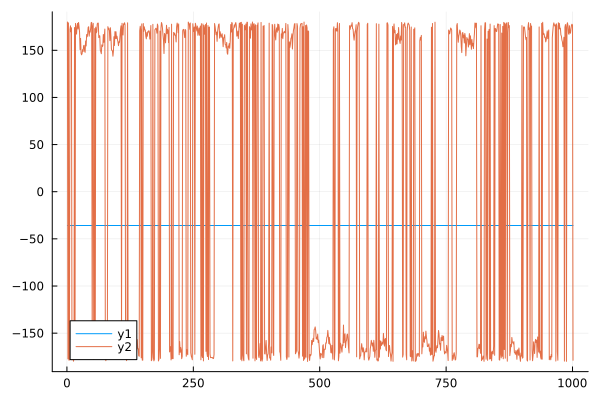

In [6]:
# This is with the default integrator

using Plots

plot(tau1_values)
plot!(tau2_values)

In [ ]:
using Statistics
using Molly
using ConstrainedDynamicsSimulator
using Unitful
using CSV
using DataFrames
using Threads

function init_system(logging_interval)
    ff_dir = joinpath(dirname(pathof(Molly)), "..", "data", "force_fields")
    ff = MolecularForceField(joinpath.(ff_dir, ["ff99SBildn.xml", "tip3p_standard.xml"])...)
    sys = System("dipeptide_nowater.pdb", ff; rename_terminal_res=false)

    function phi_wrapper(sys, args...; kwargs...)
        rad2deg(torsion_angle(sys.coords[5], sys.coords[7], sys.coords[9],
                            sys.coords[15], sys.boundary))
    end

    function psi_wrapper(sys, args...; kwargs...)
        rad2deg(torsion_angle(sys.coords[7], sys.coords[9], sys.coords[15],
                            sys.coords[17], sys.boundary))
    end

    sys = System(
        "dipeptide_nowater.pdb",
        ff;
        rename_terminal_res=false,
        loggers=(
            phi=GeneralObservableLogger(phi_wrapper, Float64, logging_interval),
            psi=GeneralObservableLogger(psi_wrapper, Float64, logging_interval),
        ),
        implicit_solvent="gbn2",
    )

    return sys
end

timestep = 0.002u"ps"
fric = 5000.0u"ps^-1"
temps = [3 * 10^(x) for x in 0:0.1:3]
traj_length = 1_000
logging_interval = 1
phi_data_array = zeros((length(temps), div(traj_length, logging_interval) + 1))
psi_data_array = zeros((length(temps), div(traj_length, logging_interval) + 1))
mean_phi_increment = zeros(length(temps))
mean_psi_increment = zeros(length(temps))

@threads for (idx, temp) in enumerate(temps)
    sys = init_system(logging_interval)
    temp = temp*u"K"
    simulator = CVConstrainedOverdampedLangevin(dt=timestep, T=temp, γ=fric, φ_grid=ConstrainedDynamicsSimulator.Dihedrals.φ_grid, φ_flat=ConstrainedDynamicsSimulator.Dihedrals.φ_flat)
    ConstrainedDynamicsSimulator.simulate!(sys, simulator, traj_length)
    phi_data_array[idx, :] = values(sys.loggers.phi)
    psi_data_array[idx, :] = values(sys.loggers.psi)
    mean_phi_increment[idx] = mean(abs.(diff(values(sys.loggers.phi))))
    mean_psi_increment[idx] = mean(abs.(diff(values(sys.loggers.psi))))
end

mean_phi_angles = vec(mean(phi_data_array, dims=2))
mean_psi_angles = vec(mean(psi_data_array, dims=2))
std_phi_angles = vec(std(phi_data_array, dims=2))
std_psi_angles = vec(std(psi_data_array, dims=2))

df = DataFrame(
    Temperature_K = temps,
    Mean_Phi_Angles = mean_phi_angles,
    Std_Phi_Angles = std_phi_angles,
    Mean_Phi_Increment = mean_phi_increment,
    Mean_Psi_Angles = mean_psi_angles,
    Std_Psi_Angles = std_psi_angles,
    Mean_Psi_Increment = mean_psi_increment
)

metadata = """
# Timestep: $(timestep)
# Friction Coefficient: $(fric)
# Trajectory Length: $(traj_length) steps
# Logging Interval: $(logging_interval)
# Temperature Range: $(minimum(temps)) K to $(maximum(temps)) K
# Number of Temperatures: $(length(temps))
"""

open("./results/EM/mean_and_std_angles.csv", "w") do io
    write(io, metadata)
    CSV.write(io, df; append=true, writeheader=true)
end

println("Results saved to mean_and_std_angles.csv")

progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 144336173941)), 0, 1, false, false, 1.742397775215447e9, 1.742397775215447e9, 1.742397775215447e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4300722896, 4300513024, -1)), 0, 1, false, false, 1.742397775427767e9, 1.742397775427767e9, 1.742397775427767e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (5709910320, 5709910352, 431792399119)), 0, 1, false, false, 1.742397775633433e9, 1.742397775633433e9, 1.742397775633433e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 2377900747084643388)), 0, 1, false, false, 1.742397775833764e9, 1.742397775833764e9, 1.742397775833764e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 141733920768)), 0, 1, false, false, 1.742397776075817e9, 1.742397776075817e9, 1.742397776075817e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 144336173941)), 0, 1, false, false, 1.742397776277502e9, 1.742397776277502e9, 1.742397776277502e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (5, 6, -281333242789888)), 0, 1, false, false, 1.742397776479636e9, 1.742397776479638e9, 1.742397776479638e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397776678322e9, 1.742397776678322e9, 1.742397776678322e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (7, 0, -1)), 0, 1, false, false, 1.742397776879789e9, 1.742397776879789e9, 1.742397776879789e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 430036378497)), 0, 1, false, false, 1.742397777082881e9, 1.742397777082881e9, 1.742397777082881e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397777282821e9, 1.742397777282821e9, 1.742397777282821e9))

Progress:  51%|████████████████████▉                    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (8, 14, 141733920768)), 0, 1, false, false, 1.74239777748339e9, 1.74239777748339e9, 1.74239777748339e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4664767233, 1, 22)), 0, 1, false, false, 1.742397777685163e9, 1.742397777685163e9, 1.742397777685163e9))

Progress:  50%|████████████████████▋                    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (13152099329, 1, 22)), 0, 1, false, false, 1.742397777934899e9, 1.742397777934899e9, 1.742397777934899e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, -281330640536715)), 0, 1, false, false, 1.742397778137442e9, 1.742397778137442e9, 1.742397778137442e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4610916787295108353, 1, 22)), 0, 1, false, false, 1.742397778337591e9, 1.742397778337591e9, 1.742397778337591e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.74239777853844e9, 1.74239777853844e9, 1.74239777853844e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 430036378497)), 0, 1, false, false, 1.742397778736625e9, 1.742397778736625e9, 1.742397778736625e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397778942657e9, 1.742397778942657e9, 1.742397778942657e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4611859651306884353, 1, 22)), 0, 1, false, false, 1.74239777913884e9, 1.74239777913884e9, 1.74239777913884e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, 4703380704)), 0, 1, false, false, 1.742397779341487e9, 1.742397779341487e9, 1.742397779341487e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397779547172e9, 1.742397779547172e9, 1.742397779547172e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (2, 1, 431322352720)), 0, 1, false, false, 1.742397779753839e9, 1.742397779753839e9, 1.742397779753839e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (5714805200, 4705868944, 4703380704)), 0, 1, false, false, 1.742397779999227e9, 1.742397779999227e9, 1.742397779999227e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397780203213e9, 1.742397780203213e9, 1.742397780203213e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.74239778040032e9, 1.74239778040032e9, 1.74239778040032e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4610890368634902137, 4610135022540745064, 22)), 0, 1, false, false, 1.742397780605907e9, 1.742397780605907e9, 1.742397780605908e9))

Progress:  51%|████████████████████▉                    |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (1, 1, 22)), 0, 1, false, false, 1.742397780808183e9, 1.742397780808183e9, 1.742397780808183e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (0, 0, -281330640536715)), 0, 1, false, false, 1.742397781010801e9, 1.742397781010801e9, 1.742397781010801e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4611468723124210433, 1, 22)), 0, 1, false, false, 1.742397781213911e9, 1.742397781213911e9, 1.742397781213911e9))

Progress:  51%|█████████████████████▏                   |  ETA: 0:00:00

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


progress = Progress(n_steps) = ProgressMeter.Progress(1000, 0, nothing, ProgressMeter.BarGlyphs('|', '█', ['▏', '▎', '▍', '▌', '▋', '▊', '▉'], ' ', '|'), ProgressMeter.ProgressCore(:green, "Progress: ", 0.1, true, 0, IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), false, 1, 0, ReentrantLock(nothing, 0x00000000, 0x00, Base.GenericCondition{Base.Threads.SpinLock}(Base.IntrusiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), (4568645510995893283, 5694363216, 22)), 0, 1, false, false, 1.742397781415803e9, 1.742397781415803e9, 1.742397781415803e9))


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


Results saved to mean_and_std_angles.csv
